In [1]:
import csv
import cv2
import numpy as np
import tensorflow as tf
from keras.models import Sequential, Model, load_model
from keras.layers import Flatten, Dense, Lambda, Cropping2D, Input, ZeroPadding2D, Dropout
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.applications.inception_v3 import InceptionV3
from keras import backend as K
from sklearn.utils import shuffle
import gc
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

Using TensorFlow backend.


'done'

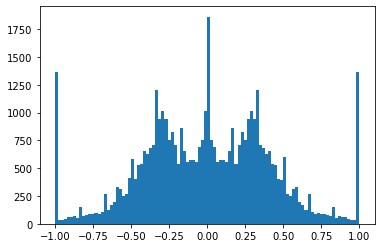

In [2]:
# Loads the driving logs of an array of folders, and returns shuffled (images, measurements).
def load_data(folders):
    images = []
    measurements = []
    for folder in folders:
        with open(folder + "/driving_log.csv") as f:
            reader = csv.reader(f)
            for line in reader:
                if line[0] != "center": # The first line of the CSV may be labels, so skip it.

                    # center
                    image = mpimg.imread(
                        folder + "/IMG/" + line[0].replace('\\','/').split('/')[-1]
                    )
                    measurement = float(line[3])
                    images.append(image)
                    measurements.append(measurement)
                    # Flip the image and measurement.
                    images.append(np.fliplr(image))
                    measurements.append(-measurement)

                    # The following adds the left and right images, with modified steering angles.
                    # They were ultimately not necessary.
                    
    #                 # left
    #                 image = cv2.imread(
    #                     folder + "/IMG/" + line[1].replace('\\','/').split('/')[-1]
    #                 )
    #                 measurement = np.clip(float(line[4]) + 0.1, -1, 1)
    #                 images.append(image)
    #                 measurements.append(measurement)
    #                 images.append(np.fliplr(image))
    #                 measurements.append(-measurement)

    #                 # right
    #                 image = cv2.imread(
    #                     folder + "/IMG/" + line[2].replace('\\','/').split('/')[-1]
    #                 )
    #                 measurement = np.clip(float(line[4]) - 0.1, -1, 1)
    #                 images.append(image)
    #                 measurements.append(measurement)
    #                 images.append(np.fliplr(image))
    #                 measurements.append(-measurement)
    
    return shuffle(
        np.array(images),
        np.array(measurements)
    )

(X_train, y_train) = load_data([
    "data/lap1",
    "data/lap2",
    "data/lap3",
    "data/backwardslap",
    "data/recovery",
#     "data/clap1",
#     "data/clap2",
#     "data/clap3",
#     "data/cbackwardslap",
#     "data/crecovery",
#     "data/ctroublesection",
])

plt.hist(y_train, 100)
"done"

In [3]:
# generate validation dataset
num_val = int(0.2 * len(X_train))
X_val = X_train[:num_val]
y_val = y_train[:num_val]
X_train = X_train[num_val:]
y_train = y_train[num_val:]

print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)

(36968, 160, 320, 3) (36968,) (9242, 160, 320, 3) (9242,)


In [ ]:
inception = InceptionV3(weights="imagenet", include_top=False,
                        input_shape=(160,320,3)) # should be 139,320,3

# Freezing the weights didn't work.
# for i in range(len(inception.layers)):
#     inception.layers[i].trainable = False

image_input = Input(shape=(160,320,3))
crop = Cropping2D(cropping=((70,25),(0,0)))(image_input)
pad = ZeroPadding2D((37,0))(crop)
inception_layer = inception(pad)
layer1 = GlobalAveragePooling2D()(inception_layer)
# layer2 = Dense(256, activation="relu")(layer1)
layer2 = Dropout(0.5)(layer1)
predictions = Dense(1)(layer2)

model = Model(inputs=image_input, outputs=predictions)
model.compile(optimizer='Adam', loss='mse')
model.summary()

In [ ]:
model = Sequential()
# model.add(Lambda(lambda x: x/255.0 - 0.5, input_shape = (160,320,3)))
model.add(Cropping2D(cropping=((70,25),(0,0)), input_shape=(160, 320, 3)))

# LeNet
# model.add(Conv2D(6, (5, 5), activation="relu"))
# model.add(MaxPooling2D())
# model.add(Conv2D(6, (5, 5), activation="relu"))
# model.add(MaxPooling2D())
# model.add(Flatten())
# model.add(Dense(120))
# model.add(Dense(84))

# NVidia example
model.add(Conv2D(24, (5, 5), strides=(2, 2), activation="relu"))
model.add(Conv2D(36, (5, 5), strides=(2, 2), activation="relu"))
model.add(Conv2D(48, (5, 5), strides=(2, 2), activation="relu"))
model.add(Conv2D(64, (3, 3), activation="relu"))
model.add(Conv2D(64, (3, 3), activation="relu"))
model.add(Flatten())
model.add(Dense(100, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(50, activation="relu"))
model.add(Dropout(0.5))

model.add(Dense(1))

model.compile(loss="mse", optimizer="adam")
model.summary()

In [5]:
# Use a generator to pre-process our images for ImageNet
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.inception_v3 import preprocess_input
datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [6]:
batch_size = 32
epochs = 1000
model.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size), 
                    steps_per_epoch=len(X_train)/batch_size, epochs=epochs, verbose=1, 
                    validation_data=val_datagen.flow(X_val, y_val, batch_size=batch_size),
                    validation_steps=len(X_val)/batch_size)

Epoch 1/1000
1156/1155 [==============================] - 204s 177ms/step - loss: 0.0248 - val_loss: 0.0161
Epoch 2/1000
1156/1155 [==============================] - 200s 173ms/step - loss: 0.0230 - val_loss: 0.0128
Epoch 3/1000
1156/1155 [==============================] - 201s 174ms/step - loss: 0.0215 - val_loss: 0.0127
Epoch 4/1000
1156/1155 [==============================] - 204s 176ms/step - loss: 0.0222 - val_loss: 0.0147
Epoch 5/1000
1156/1155 [==============================] - 201s 174ms/step - loss: 0.0226 - val_loss: 0.0171
Epoch 6/1000
1156/1155 [==============================] - 201s 174ms/step - loss: 0.0215 - val_loss: 0.0158
Epoch 7/1000
1156/1155 [==============================] - 210s 182ms/step - loss: 0.0226 - val_loss: 0.0136
Epoch 8/1000
1156/1155 [==============================] - 200s 173ms/step - loss: 0.0210 - val_loss: 0.0139
Epoch 9/1000
1156/1155 [==============================] - 209s 180ms/step - loss: 0.0220 - val_loss: 0.0129
Epoch 10/1000
1156/1155 [===

1156/1155 [==============================] - 216s 187ms/step - loss: 0.0204 - val_loss: 0.0174
Epoch 77/1000
1156/1155 [==============================] - 207s 179ms/step - loss: 0.0188 - val_loss: 0.0173
Epoch 78/1000
 203/1155 [====>.........................] - ETA: 1:49 - loss: 0.0208

KeyboardInterrupt: 

In [7]:
model.save("cmodeldropout3.h5")

In [8]:
K.clear_session()
gc.collect()
del model

In [4]:
model = load_model("cmodeldropout2.h5")

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


In [ ]:
n = 0
image = X_train[n]
image = preprocess_input(image)
image_cropped = image[70:-25]
plt.imshow(image_cropped)
steering_angle = float(model.predict(image[None, :, :, :], batch_size=1))
print(steering_angle, y_train[n])

In [ ]:
y_train = np.array([.123]*len(y_train))
plt.hist(y_train, 100)
y_train.shape

In [ ]:
TODO: add image preprocessing to drive.py